<a href="https://colab.research.google.com/github/katearb/Data-Science-Notebooks/blob/master/3_Sequence_Labeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget https://github.com/katearb/files/raw/main/ner_dataset.csv.zip

In [ ]:
!unzip /content/ner_dataset.csv.zip

Archive:  /content/ner_dataset.csv.zip
  inflating: ner_dataset.csv         


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from functools import wraps
import time
import re

In [ ]:
def timing(func):
    """timefunc's doc"""

    @wraps(func)
    def time_closure(*args, **kwargs):
        """time_wrapper's doc string"""
        start = time.perf_counter()
        result = func(*args, **kwargs)
        time_elapsed = time.perf_counter() - start
        print(f"Function: {func.__name__}, Time: {time_elapsed}")
        return result, time_elapsed

    return time_closure

In [ ]:
data = pd.read_csv(r'/content/ner_dataset.csv', encoding='unicode_escape')
data.fillna(method = 'ffill', inplace = True)

### Data Exploration

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns 

In [ ]:
data.shape

(1048575, 4)

In [ ]:
word_len = pd.Series([len(x) for x in data['Word']])

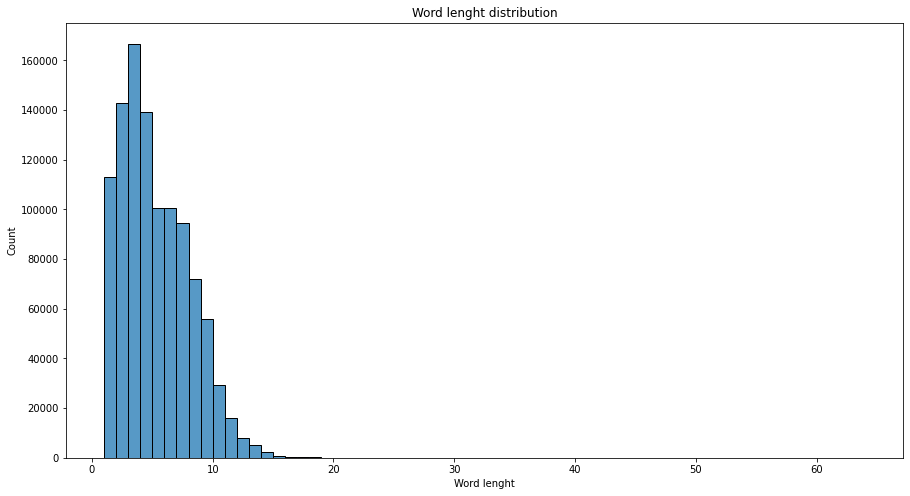

In [ ]:
plt.figure(figsize=(15, 8))
sns.histplot(data=word_len, binwidth=1)
plt.gca().set(xlabel='Word lenght', ylabel='Count', title='Word lenght distribution')
plt.show()

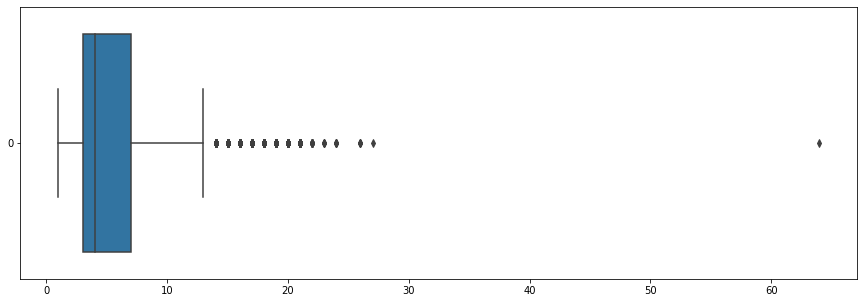

In [ ]:
plt.figure(figsize=(15, 5))
sns.boxplot(data=word_len, orient='h')

In [ ]:
# vocabulary size
print('Vocabulary size:', len(set(data['Word'])))

Vocabulary size: 35178


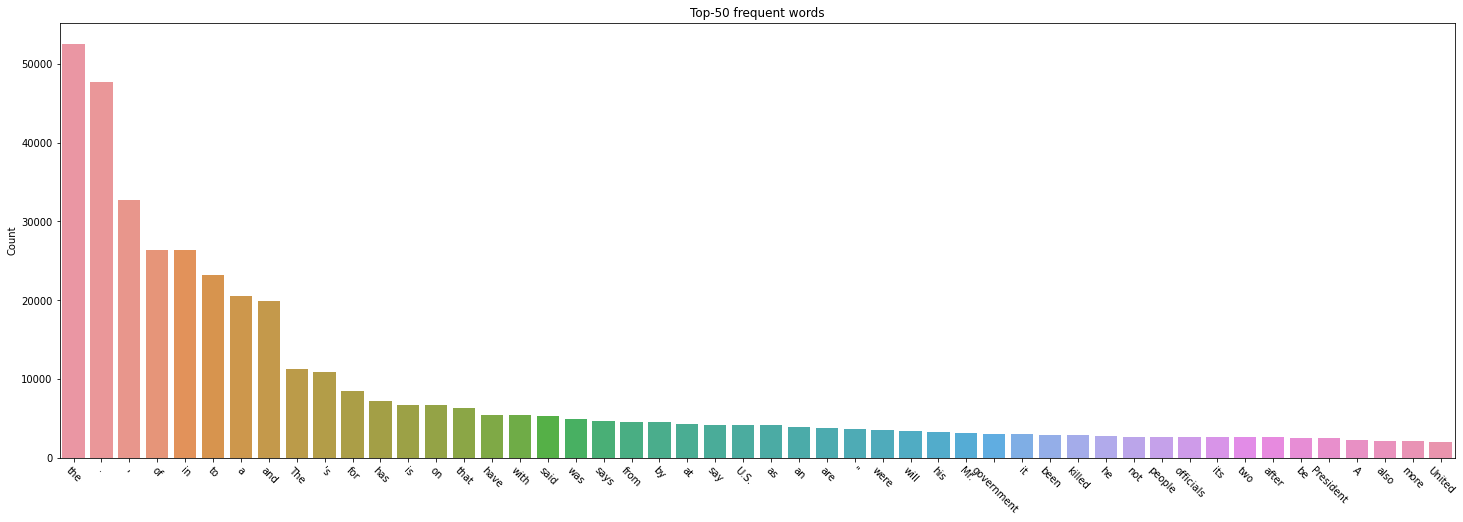

In [ ]:
# top frequent words
bar_info = data['Word'].value_counts()[:50]

plt.figure(figsize=(25, 8))
plt.xticks(rotation=-45)
plt.title('Top-50 frequent words')

sns.barplot(x=bar_info.index, y=bar_info)

plt.gca().set(ylabel='Count')
plt.show()

In the top of the most frequent words, most are stopwords and punctuation, but some NERs are persented too: U.S., Mr., President etc.

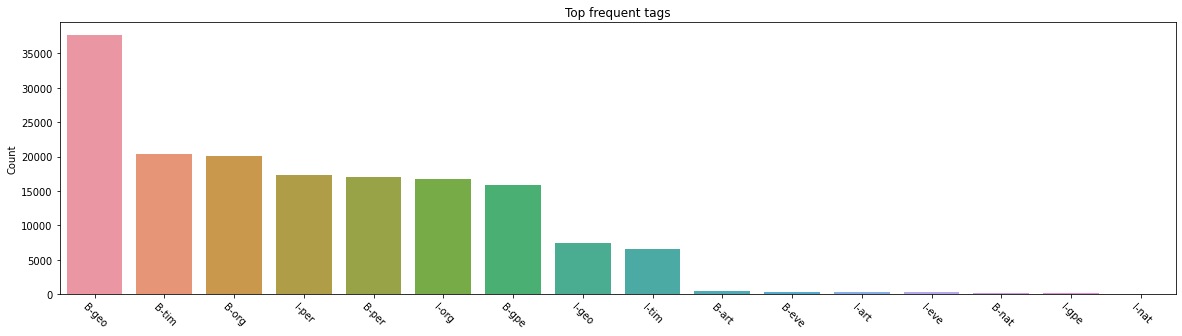

In [ ]:
# top tags
bar_info = data['Tag'].value_counts()[1:]

plt.figure(figsize=(20, 5))
plt.xticks(rotation=-45)
plt.title('Top frequent tags')

sns.barplot(x=bar_info.index, y=bar_info)

plt.gca().set(ylabel='Count')
plt.show()

Most frequent NER tag is B-geo. It is almost twice more frequent compared to the second place (B-tim). Almost a half of the tags is extremely rare: art, eve and nat.

"Per" tag is the only tag where "I" prefix is more frequent than "B" prefix. This means that most of "Per" entities contain more than > 2 tokens inside.

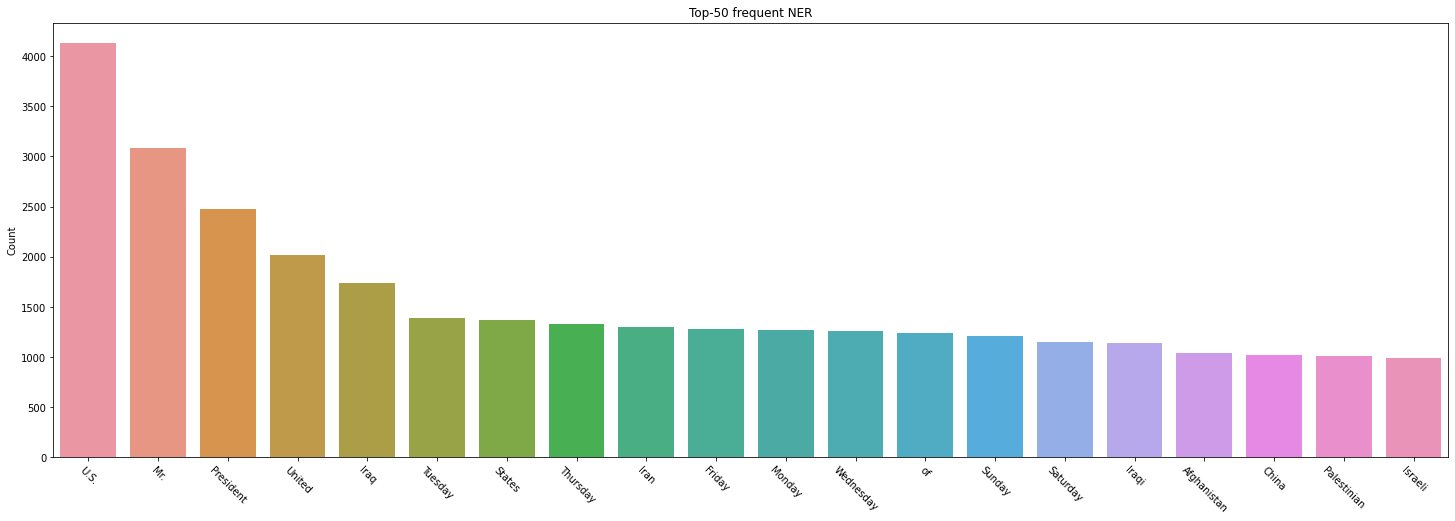

In [ ]:
# top NER
bar_info = data[data['Tag'] != 'O']['Word'].value_counts()[:20]

plt.figure(figsize=(25, 8))
plt.xticks(rotation=-45)
plt.title('Top-50 frequent NER')

sns.barplot(x=bar_info.index, y=bar_info)

plt.gca().set(ylabel='Count')
plt.show()

This bar chart explains the previous one. Most frequent ner tokens are connected with geographical places (countries names)  or are time-related (weekdays). Top-2 and top-3 tokens are person-related.

# HMM

In [ ]:
class HMMTagger():
    def __init__(self, states, observations):
        """Initialize HMM model with states and observations
        :param states: array with unique hidden states (list)
        :param observations: array with unique observations (list)
        """
        # add 'Unk' to handle unkown tokens
        self.states = states
        self.observations = [*observations, 'Unk']
        self.states_num = len(self.states)
        self.observations_num = len(self.observations)

        self.init_prob = np.zeros(shape=(1, self.states_num))
        self.transition_matrix = np.zeros(shape=(self.states_num,self.states_num))
        self.emission_matrix = np.zeros(shape=(self.states_num, self.observations_num))

        self.states_to_idx = {state:idx for idx, state in enumerate(self.states)}
        self.observations_to_idx = {obs:idx for idx, obs in enumerate(self.observations)}
        

    def _update_init_prob(self, train_data):
      initials = [sentence[0][0] for sentence in train_data]
      initials_count = {tag: initials.count(self.states_to_idx[tag]) for tag in self.states}
      total = sum(initials_count.values())

      for i, tag in enumerate(self.states):
        self.init_prob[0][i] = initials_count[tag] / total

    def _normalize(self, matrix):
        for i, row in enumerate(matrix):
            sum_val = sum(row)
            matrix[i] = row / sum_val
        return matrix

    def _update_transition_matrix(self, train_data):
        tag_seq = [[tag for tag, word in sentence] for sentence in train_data]
        transition = np.zeros(shape=(self.states_num,self.states_num))

        pair_count = np.zeros(shape=(self.states_num,self.states_num))
        tag_count = np.zeros(shape=(self.states_num))

        for sentence in tag_seq:
          for i, tag in enumerate(sentence):
            tag_count[tag] += 1
            if i > 0:
              pair_count[sentence[i-1], tag] += 1
        
        for i in range(self.states_num):
          for j in range(self.states_num):
            transition[i, j] = pair_count[i, j] / tag_count[i]
        
        self.transition_matrix = self._normalize(transition)

    def _update_emission_matrix(self, train_data):

      tag_word_count = np.zeros(shape=(self.states_num,self.observations_num))
      tag_count = np.zeros(shape=(self.states_num))
      emission = np.zeros(shape=(self.states_num, self.observations_num))

      for sentence in train_data:
        for tag, word in sentence:
          tag_count[tag] += 1
          tag_word_count[tag, word] += 1
      
      voc_size = self.observations_num
      for i in range(len(tag_count)):
        for obs in range(self.observations_num):
          emission[i, obs] = (tag_word_count[i, obs] + 1) / (tag_count[i] + voc_size)
      
      self.emission_matrix = self._normalize(emission)
      return tag_count, tag_word_count

    @timing
    def fit(self, train_data):
        """Estimate initial probability vector, transition and emission matrices
        :param train_data: list of sentecnes where each sentence is represented by list of tuples (state, observation)
        
        Example: train_data = [[('O', 'Thousands'),
                                ('O', 'of'),
                                ('O', 'demonstrators'),
                                ('O', 'have'),
                                ('O', 'marched'),
                                ('O', 'through'),
                                ('B-geo', 'London')],
                               [('B-gpe', 'Iranian'),
                                ('O', 'officials'),
                                ('O', 'say'),
                                ('O', 'they'),
                                ('O', 'expect'),
                                ('O', 'to'),
                                ('O', 'get'),
                                ('O', 'access')]]
                                
        """
        train_data = [[(self.states_to_idx[tag], 
                        self.observations_to_idx[word]) for tag, word in sentence] for sentence in train_data]
        self._update_init_prob(train_data)
        self._update_transition_matrix(train_data)
        self._update_emission_matrix(train_data)

    def __viterbi(self, obs_sequence_indices):
        """Decode incoming sequence of observations into the most propable sequence of hidden states using Viterbi algorithm
        : param obs_sequence_indices: list of observations indices
        :return: list of hidden states indices
        """
        tmp = [0]*self.states_num

        delta = [tmp[:]]  # Compute initial state probabilities
        for i in range(self.states_num):
          delta[0][i] = self.init_prob[0,i] * self.emission_matrix[i, obs_sequence_indices[0]]

        phi = [tmp[:]]

        for obs in obs_sequence_indices[1:]:  # For all observations except the inital one
          delta_t = tmp[:]
          phi_t = tmp[:]
          for j in range(self.states_num):   # Following formula 33 in Rabiner'89
            tdelta = tmp[:]
            tphimax = -1.0
            for i in range(self.states_num):
              tphi_tmp = delta[-1][i] * self.transition_matrix[i,j]
              if (tphi_tmp > tphimax):
                tphimax = tphi_tmp
                phi_t[j] = i
              tdelta[i] = tphi_tmp * self.emission_matrix[j, obs]
            delta_t[j] = max(tdelta)
          delta.append(delta_t)
          phi.append(phi_t)

        # Backtrack the path through the states  (Formula 34 in Rabiner'89)
        tmax = -1.0
        for i in range(self.states_num):
          if (delta[-1][i] > tmax):
            tmax = delta[-1][i]
            state_seq = [i]  # Last state with maximum probability

        phi.reverse()  # Because we start from the end of the sequence
        for tphi in phi[:-1]:
          state_seq.append(tphi[state_seq[-1]])
        return reversed(state_seq)

    @timing
    def predict(self, obser_seq):
        """Decode observable sequences using Viterbi algorithm
        :param obser_seq: list of sentences where each sentence is represented by list of observations
        :return: list of the most probable hidden states

        Example: obser_seq = [['The','military','says','the','blast'],
                              ['The','attack','prompted','Scandinavian','monitors','overseeing','Sri','Lanka']]
        """
        idx_to_states = {v: k for k, v in self.states_to_idx.items()}
        data = [[self.observations_to_idx[word] for word in sentence] for sentence in obser_seq]
        decoded_sequences = [self.__viterbi(sentence) for sentence in data]

        return [[idx_to_states[idx] for idx in decoded_seq] for decoded_seq in decoded_sequences]

In [ ]:
def prepare_hmm_data(data):
  take_word_tag = lambda x: [(t, w) for w, t in zip(x['Word'], x['Tag'])]
  data_grouped = data.groupby("Sentence #").apply(take_word_tag)

  return data_grouped.to_list()

In [ ]:
# prepare data got HMM
hmm_data = prepare_hmm_data(data)

# train test split
train_hmm_data, test_hmm_data = train_test_split(hmm_data, test_size=0.1, random_state=100)

test_hmm_true = [[tag for tag, word in sentence] for sentence in test_hmm_data]
test_hmm_data = [[word for tag, word in sentence] for sentence in test_hmm_data]

In [ ]:
# fit HMM
states = set(data['Tag'])
observ = set(data['Word'])
test_hmm = HMMTagger(states, observ)
_, hmm_train_time = test_hmm.fit(train_hmm_data)              

Function: fit, Time: 4.543928881999818


In [ ]:
# predict with HMM
hmm_preds, hmm_pred_time = test_hmm.predict(test_hmm_data)

Function: predict, Time: 28.961273798000093


# Spacy

In [ ]:
import spacy
from spacy import displacy
from collections import Counter
import en_core_web_sm
import re

In [ ]:
nlp = en_core_web_sm.load()

##### prepare data

In [ ]:
def get_sentences_str(data):
  join_str = lambda x: ' '.join(x['Word'])
  data_grouped = data.groupby("Sentence #").apply(join_str)
  return [s for s in data_grouped]

In [ ]:
data_spacy = get_sentences_str(data)

#### Predict

In [ ]:
@timing
def predict_tag_spacy(word_series):
  preds = []
  tokens = []
  for sentence in word_series:
    text = nlp(sentence)
    preds.extend([X.ent_type_ for X in text])
    tokens.extend(text)
  
  return preds, tokens

In [ ]:
spacy_preds,  spacy_pred_time = predict_tag_spacy(data_spacy)

Function: predict_tag_spacy, Time: 555.7774025869985


Spacy is pretrained so it doesn't require fit step.

While working with spacy I faced several problems:

1. Spacy uses its own tagger and its tokenization doesn't match the given one which makes comparing preds and ground truth impossible.
2. Spacy has its own tagging which doesn't match the given one. It is connected not only with the fact that BIOS-tagging is used in the dataset but not in the spacy tagging, but also the semantic content of the spacy tags does not match and cannot be converted to the given tags unambiguously.

In [ ]:
spacy_tokens = spacy_preds[1]
spacy_preds = spacy_preds[0]

In [ ]:
spacy_preds = [pred if pred != '' else 'O' for pred in spacy_preds]

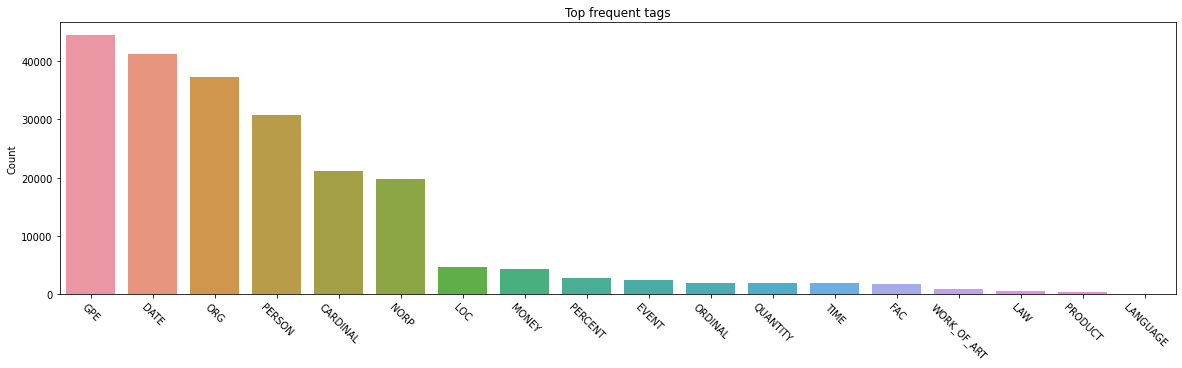

In [ ]:
bar_info = pd.Series(spacy_preds).value_counts()[1:]

plt.figure(figsize=(20, 5))
plt.xticks(rotation=-45)
plt.title('Top frequent tags')

sns.barplot(x=bar_info.index, y=bar_info)

plt.gca().set(ylabel='Count')
plt.show()

The distribution of tags predicted by spacy is similar to the ground truth distribution -- the tags in the top are in the same sequence: GPE (geo), DATE (tim), ORG (org), PERSON (per).

Both WORK_OF_ART anf the original "art" are closely connected and are placed in the second half of the top. Same id for EVENT and eve, but as I have already mentioned these tags might represented a lit bit different tags so they cannot be translated obviously.

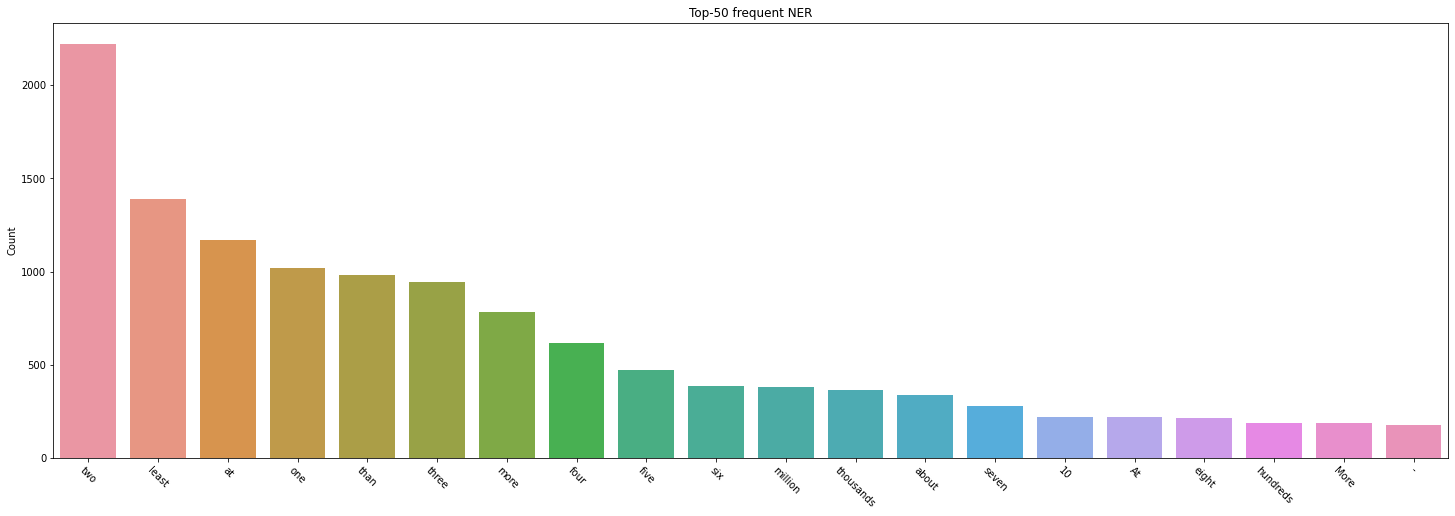

In [ ]:
# top NER
spacy_tokens = [str(token) for token in spacy_tokens]
spacy_data = pd.DataFrame([spacy_tokens, spacy_preds]).T
spacy_data.columns = ['tokens', 'preds']

bar_info = spacy_data[spacy_data['preds'] == 'CARDINAL']['tokens'].value_counts()[:20]

plt.figure(figsize=(25, 8))
plt.xticks(rotation=-45)
plt.title('Top-50 frequent NER')

sns.barplot(x=bar_info.index, y=bar_info)

plt.gca().set(ylabel='Count')
plt.show()

Top of the most frequent NER tokens looks different from the original distribution. All of the tokens are numbers related: it could be dates or money. However, we do not see here any geopolitical tokens that are widely spread through the original NER top.

# CRF

In [ ]:
!pip install sklearn_crfsuite
!pip install -U 'scikit-learn<0.24'

In [ ]:
from sklearn.model_selection import cross_val_predict
from sklearn_crfsuite.metrics import flat_classification_report
from sklearn_crfsuite import CRF

### prepare data

In [ ]:
class SentenceGetter(object):
    
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [ ]:
def word2features(sent, i):
    word = sent[i][0]
    postag = sent[i][1]

    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        'postag': postag,
        'postag[:2]': postag[:2],
    }
    if i > 0:
        word1 = sent[i-1][0]
        postag1 = sent[i-1][1]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
            '-1:postag': postag1,
            '-1:postag[:2]': postag1[:2],
        })
    else:
        features['BOS'] = True

    if i < len(sent)-1:
        word1 = sent[i+1][0]
        postag1 = sent[i+1][1]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
            '+1:postag': postag1,
            '+1:postag[:2]': postag1[:2],
        })
    else:
        features['EOS'] = True

    return features


def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [label for token, postag, label in sent]

def sent2tokens(sent):
    return [token for token, postag, label in sent]

In [ ]:
# prepare data
getter = SentenceGetter(data)
sentences = getter.sentences

X = [sent2features(s) for s in sentences]
y = [sent2labels(s) for s in sentences]

# train test split
crf_x_train, crf_x_test, crf_y_train, crf_y_test = train_test_split(X, y, test_size=0.1, 
                                                    random_state=100)

In [ ]:
# define model
crf = CRF(algorithm='lbfgs',
          c1=0.1,
          c2=0.1,
          max_iterations=100,
          all_possible_transitions=False)

In [ ]:
@timing
def fit_crf(X, y, crf):
  crf.fit(X, y)

In [ ]:
# fit crf
_, crf_train_time = fit_crf(crf_x_train, crf_y_train, crf)

Function: fit_crf, Time: 330.2442900789997


In [ ]:
@timing
def predict_crf(X, crf):
  return crf.predict(X)

In [ ]:
# predict with crf
crf_pred, crf_pred_time = predict_crf(crf_x_test, crf)

Function: predict_crf, Time: 1.7301195620002545


# BERT

In [ ]:
!pip install transformers
!pip install pytorch_lightning

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizerFast, BertConfig, BertForTokenClassification
from torch import cuda
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint

#### prepare data

In [ ]:
def get_sentence_tags(data):
  sentences_tags = []
  sentence_numbers = data['Sentence #'].unique()
  for number in sentence_numbers:
    sentence_info = data[data['Sentence #'] == number]
    sentence_str = sentence_info['Word']
    sentence_tags = ','.join(sentence_info['Tag'])
    sentences_tags.append([sentence_str, sentence_tags])
  
  return pd.DataFrame(sentences_tags, columns=['Sentence', 'Tags'])

In [ ]:
# data_bert = get_sentence_tags(data)
# data_bert.to_csv('data_bert.csv')

In [ ]:
def load_data_bert(path):
  data_bert = pd.read_csv(path,
                          index_col=0)
  sentences = []
  for i, sent in enumerate(data_bert['Sentence']):
    sent = re.split('\n\d+ +', sent)
    sent[0] = re.sub('\d+ +', '', sent[0])
    sent[-1] = re.sub('\nName: Word, dtype: object', '', sent[-1])
    sentences.append(sent)
  data_bert['Sentence'] = sentences
  
  return data_bert

In [ ]:
class BertDataset(Dataset):
    def __init__(self, tokenizer, sentences, labels, max_len):
        self.len = len(sentences)
        self.sentences = sentences
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __getitem__(self, index):
        sentence = self.sentences[index]
        inputs = self.tokenizer.encode_plus(
            sentence,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True,
            truncation='longest_first',
            is_split_into_words=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']

        label = [labels2ids[label] for label in self.labels[index].split(',')][:len(ids)-2]
        label = [0] + label + [0] * self.max_len
        label = label[:self.max_len]

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'tags': torch.tensor(label, dtype=torch.long)
        } 
    
    def __len__(self):
        return self.len

In [ ]:
# load pre-prepared data
data_bert = load_data_bert('https://raw.githubusercontent.com/katearb/files/main/data_bert2.csv')

labels2ids = {label: i for i, label in enumerate(data['Tag'].unique())}

In [ ]:
# train-test split
tokenizer = BertTokenizerFast.from_pretrained('bert-base-cased')
MAX_LEN = 50

train_dataset, test_dataset = train_test_split(data_bert, test_size=0.1, )
train_dataset, val_dataset = train_test_split(train_dataset, test_size=0.1)

train_dataset.index = [i for i in range(len(train_dataset))]
val_dataset.index = [i for i in range(len(val_dataset))]
test_dataset.index = [i for i in range(len(test_dataset))]


print("FULL Dataset: {}".format(data_bert.shape))
print("TRAIN Dataset: {}".format(train_dataset.shape))
print("VAL Dataset: {}".format(val_dataset.shape))
print("TEST Dataset: {}".format(test_dataset.shape))

# define datasets
training_set = BertDataset(tokenizer, train_dataset['Sentence'], train_dataset['Tags'], MAX_LEN)
validating_set = BertDataset(tokenizer, val_dataset['Sentence'], val_dataset['Tags'], MAX_LEN)
testing_set = BertDataset(tokenizer, test_dataset['Sentence'], test_dataset['Tags'], MAX_LEN)

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

FULL Dataset: (47959, 2)
TRAIN Dataset: (38846, 2)
VAL Dataset: (4317, 2)
TEST Dataset: (4796, 2)


In [ ]:
# define data loaders
TRAIN_BATCH_SIZE = 4
VALID_BATCH_SIZE = 2

train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 2
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': False,
                'num_workers': 2
                }

training_loader = DataLoader(training_set, **train_params)
validation_loader = DataLoader(validating_set, **test_params)
test_loader = DataLoader(testing_set, **test_params)

### Define model

In [ ]:
device = 'cuda' if cuda.is_available() else 'cpu'
print(device)

EPOCHS = 2
LEARNING_RATE = 1e-05

In [ ]:
class BertModel(pl.LightningModule):

    def __init__(self,):
        super(BertModel, self).__init__()
        model = BertForTokenClassification.from_pretrained('bert-base-uncased', num_labels=len(labels2ids))
        self.model = model

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(
                self.model.parameters(),
                lr=2e-5,
                )
        return optimizer

    def training_step(self, batch, batch_idx):
        labels = batch["tags"]
        input_ids = batch["ids"]
        attention_mask = batch["mask"]

        loss, _ = self.model(
                input_ids,
                attention_mask=attention_mask,
                labels=labels,
                return_dict=False
                )

        self.log('train_loss', loss)

        return loss

    def validation_step(self, batch, batch_idx):
        labels = batch["tags"]
        input_ids = batch["ids"]
        attention_mask = batch["mask"]

        loss, logits = self.model(
                input_ids,
                attention_mask=attention_mask,
                labels=labels,
                return_dict=False)
        
        preds = torch.argmax(logits, dim=1)

        correct_count = sum([torch.sum(lab[:len(pred)] == pred) for lab, pred in zip(labels, preds)])

        if self.on_gpu:
            correct_count = correct_count.cuda(loss.device.index)

        self.log('val_loss', loss)

In [ ]:
@timing
def make_bert_predictions(model, test_loader):
  with torch.no_grad():
    bert_preds = []
    for batch_ndx, sample in enumerate(test_loader):
      input_ids = sample["ids"]
      attention_mask = sample["mask"]
      sent_lengths = torch.sum(attention_mask, dim=1)

      logits = model(
              input_ids,
              attention_mask=attention_mask,
              return_dict=False
              )
      preds = torch.argmax(logits[0], dim=2)
      preds = [sent[:sent_len] for sent, sent_len in zip (preds, sent_lengths)]
      bert_preds.extend(preds)

  return bert_preds

In [ ]:
# checkpoint_callback = ModelCheckpoint(dirpath=r'/content/drive/MyDrive/ner_bert_checkpoints2')
# model = BertModel()
# trainer = pl.Trainer(gpus=1, precision=16, limit_train_batches=0.5, callbacks=[checkpoint_callback], default_root_dir=r'/content/drive/MyDrive/ner_bert_checkpoints3')

In [ ]:
# trainer.fit(model, training_loader, validation_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Missing logger folder: /content/drive/MyDrive/ner_bert_checkpoints3/lightning_logs

  | Name  | Type                       | Params
-----------------------------------------------------
0 | model | BertForTokenClassification | 108 M 
-----------------------------------------------------
108 M     Trainable params
0         Non-trainable params
108 M     Total params
217.809   Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [ ]:
# load pretrained model
bert_model = BertModel.load_from_checkpoint('/content/drive/MyDrive/ner_bert_checkpoints2/epoch=3-step=19423.ckpt')
bert_model.eval()

In [ ]:
# predict with bert
bert_preds, bert_pred_time = make_bert_predictions(bert_model.model, test_loader)

Function: make_bert_predictions, Time: 1031.379366694


BERT contains its own tokenizer either and it doesn't match the given one even if the data is given to the tokenizer in list-form. So, I keep only those sentences which tokenization is the same as the original one to make comparison.

In [ ]:
matched = []
matched_ids = []

# take preds and their ids if its length is the same as number of ground truh tags
for i, pred in enumerate(bert_preds):
  if (len(pred) - 2) == len(test_dataset.iloc[i, :]['Tags'].split(',')):
    matched.append(pred[1:-1])
    matched_ids.append(i)

# make one list with tokens
bert_preds_flatten = []
for pred in matched:
  bert_preds_flatten.extend(pred)

# make list of true sentences
bert_true = []
for batch in test_loader:
  t1, t2 = batch['tags']
  m1, m2 = batch['mask']
  sent_l1, sent_l2 = torch.sum(m1), torch.sum(m2)
  bert_true.append(t1[1:sent_l1-1])

# take only those which predictions we took earlier
bert_true_matched = []
for i, tag in enumerate(bert_true):
  if i in matched_ids: bert_true_matched.extend(tag)


bert_true = [*map(lambda x: x.item(), bert_true_matched)]
bert_preds = [*map(lambda x: x.item(), bert_preds_flatten)]

# Bidirectional LSTM


In [ ]:
from random import random
from numpy import array
from numpy import cumsum
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import TimeDistributed
from keras.layers import Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping 

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Model,Input
from tensorflow.keras.layers import LSTM,Embedding,Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D,Bidirectional

#### prepare data

In [ ]:
class Get_sentence(object):
    def __init__(self,data):
        self.n_sent=1
        self.data = data
        agg_func = lambda s:[(w,p,t) for w,p,t in zip(s["Word"].values.tolist(),
                                                     s["POS"].values.tolist(),
                                                     s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]

In [ ]:
getter = Get_sentence(data)
sentence = getter.sentences

In [ ]:
words = list(set(data["Word"].values))
words.append("ENDPAD")
num_words = len(words)

words_tag = list(set(data["Tag"].values))
num_words_tag = len(words_tag)

In [ ]:
word_idx = {w : i+1 for i, w in enumerate(words)}
tag_idx = labels2ids  

idx_word  = {v: k for k, v in word_idx.items()}
idx_tag = {v: k for k, v in tag_idx.items()}

In [ ]:
# padding
max_len = 50
X = [[word_idx[w[0]] for w in s] for s in sentence]
X = pad_sequences(maxlen=max_len, sequences=X, padding='post', value=num_words-1)

y = [[tag_idx[w[2]] for w in s] for s in sentence]
y = pad_sequences(maxlen=max_len, sequences=y, padding='post', value=tag_idx['O'])
y = [to_categorical(i, num_classes=num_words_tag) for i in  y]

In [ ]:
# train test split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1, 
                                                    random_state=100)

### Build model

In [ ]:
input_word = Input(shape = (max_len,))
model = Embedding(input_dim=num_words, output_dim=max_len, input_length=max_len)(input_word)
model = SpatialDropout1D(0.1)(model)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
out = TimeDistributed(Dense(num_words_tag, activation='softmax'))(model)
model = Model(input_word,out)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50)]              0         
                                                                 
 embedding (Embedding)       (None, 50, 50)            1758950   
                                                                 
 spatial_dropout1d (SpatialD  (None, 50, 50)           0         
 ropout1D)                                                       
                                                                 
 bidirectional (Bidirectiona  (None, 50, 200)          120800    
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, 50, 17)           3417      
 ibuted)                                                         
                                                             

In [ ]:
model.compile(optimizer = 'adam',loss = 'categorical_crossentropy',metrics = ['accuracy'])

### Train model

In [ ]:
early_stopping = EarlyStopping(monitor = 'val_accuracy',patience =2,verbose = 0,mode = 'max',restore_best_weights = False)
callbacks = [early_stopping]

history = model.fit(
    x_train,np.array(y_train),
    validation_split=0.2,
    batch_size = 64,
    epochs = 3,
    verbose =1
)

In [ ]:
@timing
def make_bilstm_predictions(model, x_test):
  preds = []
  i = 0
  for text in x_test:
    preds.append(np.argmax(model.predict(np.array([text])), axis=-1)[0])
    i += 1

    if i% 100 == 0:
      print(i)
  return preds

In [ ]:
# make predictions wth BiLSTM-model
bilstm_preds, bilstm_pred_time = make_bilstm_predictions(model, x_test)

In [ ]:
bilstm_y_test = np.argmax(np.array(y_test), axis=2)

# Evaluation

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
hmm_preds_flat = [item for sent in hmm_preds for item in sent]
hmm_true_flat = [item for sent in test_hmm_true for item in sent]

In [ ]:
# HMM
display(classification_report(hmm_true_flat, hmm_preds_flat))

              precision    recall  f1-score   support

       B-art       0.00      0.00      0.00         0
       B-eve       0.00      0.00      0.00         1
       B-geo       0.87      0.82      0.84      4082
       B-gpe       0.91      0.89      0.90      1675
       B-nat       0.00      0.00      0.00         0
       B-org       0.60      0.78      0.68      1541
       B-per       0.70      0.79      0.74      1505
       B-tim       0.78      0.92      0.84      1733
       I-art       0.00      0.00      0.00         0
       I-eve       0.06      1.00      0.11         2
       I-geo       0.68      0.75      0.72       687
       I-gpe       0.45      1.00      0.62        10
       I-nat       0.00      0.00      0.00         0
       I-org       0.75      0.68      0.72      1768
       I-per       0.92      0.75      0.83      2103
       I-tim       0.43      0.86      0.57       330
           O       0.99      0.98      0.99     89770

    accuracy                           0.96    105207
    macro avg       0.48      0.60      0.50    105207
    weighted avg       0.96      0.96      0.96    105207

In [ ]:
crf_preds_flat = [item for sent in crf_pred for item in sent]
crf_true_flat = [item for sent in crf_y_test for item in sent]

In [ ]:
# CRF
classification_report(crf_true_flat, crf_preds_flat)

              precision    recall  f1-score   support

       B-art       0.62      0.20      0.30        41
       B-eve       0.43      0.30      0.36        33
       B-geo       0.86      0.92      0.89      3884
       B-gpe       0.97      0.95      0.96      1651
       B-nat       0.50      0.35      0.41        17
       B-org       0.81      0.73      0.77      1997
       B-per       0.86      0.84      0.85      1689
       B-tim       0.94      0.89      0.91      2058
       I-art       0.20      0.03      0.05        39
       I-eve       0.35      0.17      0.23        36
       I-geo       0.84      0.80      0.82       757
       I-gpe       1.00      0.55      0.71        22
       I-nat       0.50      0.43      0.46         7
       I-org       0.80      0.80      0.80      1604
       I-per       0.86      0.90      0.88      1719
       I-tim       0.85      0.76      0.80       662
           O       0.99      0.99      0.99     88991

    accuracy                           0.97    105207
    macro avg       0.73      0.62      0.66    105207
    weighted avg       0.97      0.97      0.97    105207

In [ ]:
# BERT
classification_report([*map(lambda x: idx_tag[x], bert_true)], 
                      [*map(lambda x: idx_tag[x], bert_preds)])

              precision    recall  f1-score   support

       B-art       0.00      0.00      0.00         8
       B-eve       0.50      0.40      0.44         5
       B-geo       0.88      0.91      0.89       466
       B-gpe       0.99      0.92      0.95       228
       B-nat       0.00      0.00      0.00         2
       B-org       0.71      0.82      0.76       214
       B-per       0.71      0.71      0.71        59
       B-tim       0.92      0.86      0.89       341
       I-art       0.00      0.00      0.00        10
       I-eve       0.00      0.00      0.00         5
       I-geo       0.90      0.78      0.83       100
       I-gpe       0.00      0.00      0.00         1
       I-org       0.71      0.92      0.80       156
       I-per       0.84      0.84      0.84        32
       I-tim       0.87      0.76      0.81       128
           O       0.99      0.99      0.99     14860

    accuracy                           0.98     16615
    macro avg       0.56      0.56      0.56     16615
    weighted avg       0.98      0.98      0.98     16615

In [ ]:
#BiLSTM
classification_report([*map(lambda x: idx_tag[x], bilstm_y_test.flatten())],
                      [*map(lambda x: idx_tag[x], np.array(bilstm_preds).flatten())])

              precision    recall  f1-score   support

       B-art       0.00      0.00      0.00        41
       B-eve       0.00      0.00      0.00        33
       B-geo       0.83      0.88      0.86      3884
       B-gpe       0.95      0.94      0.94      1648
       B-nat       0.00      0.00      0.00        17
       B-org       0.81      0.63      0.71      1993
       B-per       0.85      0.77      0.81      1687
       B-tim       0.92      0.87      0.90      2056
       I-art       0.00      0.00      0.00        39
       I-eve       0.00      0.00      0.00        36
       I-geo       0.80      0.70      0.75       757
       I-gpe       0.00      0.00      0.00        22
       I-nat       0.00      0.00      0.00         7
       I-org       0.76      0.75      0.75      1601
       I-per       0.83      0.87      0.85      1716
       I-tim       0.76      0.76      0.76       662
           O       0.99      1.00      1.00    223601

    accuracy                           0.98    239800
    macro avg       0.50      0.48      0.49    239800
    weighted avg       0.98      0.98      0.98    239800


So, the average results are almost the same for each model: accuracy is 97-98% which is caused by the high disbalance in the tags. While the majority O-tag's accuracy is extremely high, the marked tags do not feel so well. Some of them experience 0 repcision and 0 recall (e g art, nat and eve tags which are most minor tags). Most frequent ner tags are doing better (95 and 94 precision and recall respectively for B-gpe tag). These patterns are observed across all the models.

In general, B-tags have better metrics than I-tags for the according classes. This means that the models do not recognize full entities well. So, in terms of full entities metrics would show worse results.

Looking at macro metrics (where the influence of the majority class is the lowest), Bi-LSTM shows the lowest results compared to other models. CRF demonstrates the highest macro metrics. BERT results are something between BiLSTM and CRF.

In [ ]:
bert_train_time = 9000
bilstm_train_time = 490

In [ ]:
pd.DataFrame([
              ['HMM', hmm_train_time, hmm_pred_time, 96],
              ['CRF', crf_train_time, crf_pred_time, 97],
              ['BERT', bert_train_time, bert_pred_time, 98],
              ['BiLSTM', bilstm_train_time, bilstm_pred_time, 98],
              ['Spacy', '-', spacy_pred_time * 0.1, '-']
              ], 
             columns=['Model', 'train_time', 'pred_time', 'Accuracy'])

,Model,train_time,pred_time,Accuracy
0,HMM,4.543929,28.961274,96
1,CRF,330.24429,1.730120,97
2,BERT,9000,1031.379367,98
3,BiLSTM,490,449.967572,98
4,Spacy,-,55.577740,-


In terms of required time, the models behauve differently.

Spacy is ready-to-use straight after import. HMM model requires rally little time to fit. On the third place, CRF stays with 330 secs to get fitted. Bi-LSTM and BERT finish the top with 490 and 9000 sec respectively. Most time consuming  models are tend to show the best results.

In terms of prediction time, the top would look differently. The fastest model is CRF that requires only ~2 sec to predict 10% of our data. HMM and spacy show comparable results. And Bi-LSTM requires almost 10 times more time. Anti-record here belongs to BERT again that took >1000 sec to make predictions.

#### Conclusion

Taking into consideration metrics and time recorded for fit and predict, my choice here would be CRF model as:
1. It shows the highest macro-metrics and metrics per marked classes.
2. It requires much less time to fit compared to NN-models and the smallest amount of time to make prediction compared to all other models.

CRF is a reasonable compromise between time and quality of predictions.